In [1]:
import h5py
import numpy as np
import pandas as pd
import os
import pandas as pd
import seaborn as sn
import torch
import torchvision.models as models
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from IPython.core.display import display
from collections.abc import Mapping
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/tmp/ipykernel_15034/3888904027.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [2]:
#User Input
sim = 'DR3_lsr012' #input("DR2 or DR3: ")
dim = '5D' #input("Input how many dimensions are needed: ")
galaxy = 'm12i' #input("Use m12i or m12f data: ")
transfer = True #bool(input("Transfer learning (True or False): "))
if transfer == True:
    transfer_galaxy = 'm12i' #input("Which galaxy parameters for transfer learning: ")

# Training data
if dim == '4D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec']
elif dim == '5D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax']
elif dim == '6D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity']
elif dim == '7D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'feh']
elif dim == '9D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Jr', 'Jphi', 'Jz']
elif dim == '10D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Jr', 'Jphi', 'Jz', 'feh']
    
y_key = 'is_accreted'

# Directories
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/GaiaDR3_data_reduced.hdf5'
out_dir = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/' + dim
roc_title = sim + '_' + galaxy + '_' + dim

# Parameters
learning_rate = 1e-3
batch_size = 1024
roc_path = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/' + 'roc_parameters.hdf5'

if transfer == True:
    transfer_checkpoint = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim +'/'+ transfer_galaxy +'/'+ dim + '/training_logs/version_0/checkpoints/last.ckpt'

train_parameter_file = out_dir + '/training_parameters.hdf5'
train_log = out_dir + '/training_logs'
checkpoint = train_log + '/version_0/checkpoints/last.ckpt'

In [3]:
data = []
f = h5py.File(path, 'r')

for i in x_keys:
    data.append(f[i][:])
y = f[y_key][:]

# Getting rid of nan values
x = []
if 'Jr' in x_keys:
    Jr = f['Jr'][:]
    mask = (~np.isnan(Jr))
    for i in range(len(x_keys)):
        new = data[i][:][mask]
        x.append(new)
    y = y[mask]
elif 'radial_velocity' in x_keys:
    rv = f['radial_velocity'][:]
    mask = (~np.isnan(rv))
    for i in range(len(x_keys)):
        new = data[i][:][mask]
        x.append(new)
    y = y[mask]
else:
    x = data

x = np.vstack(x).T
f.close()

In [4]:
with h5py.File(train_parameter_file, 'r') as f:
    shuffle = f['shuffle'][:]

x = x[shuffle]
y = y[shuffle]

In [5]:
n_train = int(0.9 *len(x))
n_val = len(x)-n_train
train_x, val_x = x[:n_train], x[n_train: n_train+n_val]
train_y, val_y = y[:n_train], y[n_train: n_train+n_val]

ny1 = np.sum(train_y==1)
ny0 = np.sum(train_y==0)
ny = ny1 + ny0
w1 = ny/ny1
w0 = ny/ny0
weight = torch.tensor([w0, w1], dtype=torch.float32)
mean_train_x = np.mean(train_x, axis = 0)
stdv_train_x = np.std(train_x, axis = 0)
train_x = (train_x - mean_train_x) / stdv_train_x
val_x = (val_x - mean_train_x) / stdv_train_x
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.long)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

In [6]:
class Model(LightningModule):
    def __init__(self, transfer):
        self.feature_extractor = FeatureExtractorModel()
        self.classifier = Classifier
        if transfer:
             self.feature_extractor.freeze()
                
    def __init__(self, weight, mean_train_x, stdv_train_x):
        super().__init__()
        self.save_hyperparameters()
        self.l1 = torch.nn.Linear(len(x_keys), 100) 
        self.l2 = torch.nn.Linear(100, 50)
        self.l3 = torch.nn.Linear(50, 2)
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.weight = weight
        self.mean_train_x = mean_train_x
        self.stdv_train_x = stdv_train_x

    def forward(self, x):
        x_out = self.l1(x)
        x_out = torch.relu(x_out)
        x_out = self.l2(x_out)
        x_out = torch.relu(x_out)
        x_out = self.l3(x_out)
        return x_out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
    
    def training_step(self, batch, batch_nb):
        train_x, train_y = batch 
        preds = self(train_x)
        loss = F.cross_entropy(preds, train_y, weight = self.weight.to(self.device))
        self.train_acc(preds, train_y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_nb):
        val_x, val_y = batch
        preds = self(val_x)
        loss = F.cross_entropy(preds, val_y, weight=self.weight.to(self.device))
        self.valid_acc(preds, val_y)
        self.log('val_loss', loss)
        self.log('valid_acc', self.valid_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

In [12]:
if transfer == True:
    model = Model.load_from_checkpoint(transfer_checkpoint, transfer=True)
else:
    model = Model(transfer=False)
mean = model.mean_train_x
stdv = model.stdv_train_x
weight = model.weight

n_test = n_val
test_x = x[n_train: n_train+n_test]
test_y = y[n_train: n_train+n_test]

test_x = (test_x - mean) / stdv

test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.long)

test_dataset = list(zip(test_x, test_y))
test_loader = DataLoader(test_dataset, batch_size = batch_size)

In [13]:
len(y), len(x), len(shuffle), 1133904+5636

(8593425, 8593425, 8593425, 1139540)

In [20]:
predict = []
target = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        yhat = model(x)
        predict.append(yhat.cpu().numpy())
        target.append(y.cpu().numpy())
predict = np.concatenate(predict)
target = np.concatenate(target)

score = np.exp(predict[:,1])/(np.exp(predict[:,0])+np.exp(predict[:,1]))
target_true_mask = (target==True)
target_false_mask = (target==False)

thresholds = np.linspace(0.001, 1, 100)
precision = []
recall = []
epsilon_a = []
epsilon_i = []
for thres in thresholds:
    score_1 = score>thres
    score_1_true_mask = (score_1==True)
    score_1_false_mask = (score_1==False)
    TP = np.sum(score_1[target_true_mask])
    FP = np.sum(score_1[target_false_mask])
    TN = np.sum(~score_1[target_false_mask])
    FN = np.sum(~score_1[target_true_mask])
    N_a = TP + FN
    N_i = TN + FP
    N_a_s = TP
    N_i_s = FP
    epsilon_a_thres = N_a_s / N_a
    epsilon_i_thres = N_i_s / N_i
    epsilon_a.append(epsilon_a_thres)
    epsilon_i.append(epsilon_i_thres)

/tmp/ipykernel_15034/3071458566.py:14: RuntimeWarning: overflow encountered in exp
  score = np.exp(predict[:,1])/(np.exp(predict[:,0])+np.exp(predict[:,1]))


In [24]:
score_a = score[target==True]
score_i = score[target==False]

(array([2.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 5.00000e+00, 8.00000e+00, 7.70000e+01, 8.59249e+05]),
 array([-197.86594 , -177.14122 , -156.4165  , -135.69177 , -114.96706 ,
         -94.24234 ,  -73.517624,  -52.7929  ,  -32.06818 ,  -11.343462,
           9.381257], dtype=float32),
 <BarContainer object of 10 artists>)

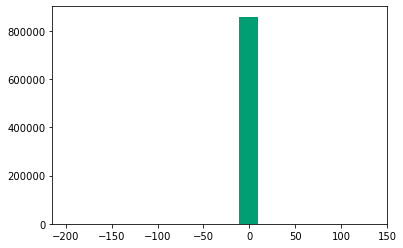

In [22]:
plt.hist(predict[:,0])
plt.hist(predict[:,1])

In [15]:
np.sum(np.isinf(score))

0

(0,
 (array([1.123437e+06, 1.282000e+03, 8.820000e+02, 7.280000e+02,
         6.630000e+02, 6.520000e+02, 7.270000e+02, 8.860000e+02,
         1.459000e+03, 8.824000e+03]),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
        dtype=float128),
  <BarContainer object of 10 artists>))

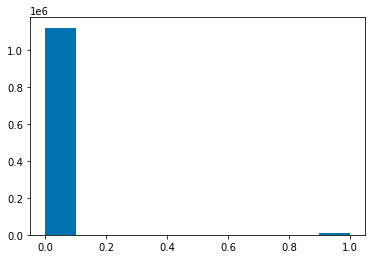

In [45]:
np.sum(np.isnan(score)), plt.hist(score)

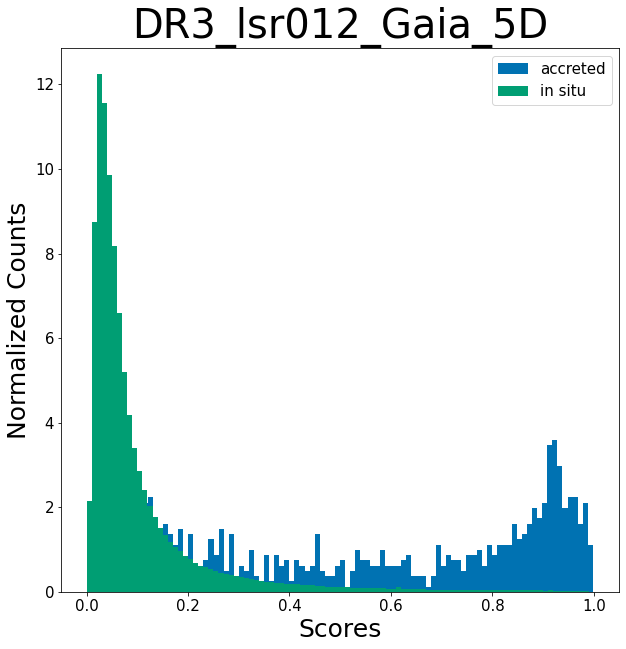

In [25]:
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.hist(score_a, bins=100, density=True, label='accreted')
ax.hist(score_i, bins=100, density=True, label='in situ')
ax.set_title(roc_title, fontsize=40)
ax.set_xlabel('Scores', fontsize=25)
ax.set_ylabel('Normalized Counts', fontsize=25)
ax.tick_params(axis='both', labelsize=15)
#plt.xlim([0,1])
# plt.ylim([0,25])
ax.legend(loc='upper right', fontsize=15)

In [71]:
np.sum(target==True), np.sum(target==False)

(5636, 1133904)

In [21]:
thresholds = np.linspace(0.001, 1, 1000)
precision = []
recall = []
epsilon_a = []
epsilon_i = []
for thres in thresholds:
    score_1 = score>thres
    score_1_true_mask = (score_1==True)
    score_1_false_mask = (score_1==False)
    TP = np.sum(score_1[target_true_mask])
    FP = np.sum(score_1[target_false_mask])
    TN = np.sum(~score_1[target_false_mask])
    FN = np.sum(~score_1[target_true_mask])
    N_a = TP + FN
    N_i = TN + FP
    N_a_s = TP
    N_i_s = FP
    epsilon_a_thres = N_a_s / N_a
    epsilon_i_thres = N_i_s / N_i
    epsilon_a.append(epsilon_a_thres)
    epsilon_i.append(epsilon_i_thres)

In [68]:
epsilon_a = np.array(epsilon_a)
epsilon_i = np.array(epsilon_i)
np.sum(epsilon_a > 0.6), np.sum(epsilon_i>0.0175)

(0, 0)

([<matplotlib.lines.Line2D at 0x145c00c28a30>], 23224)

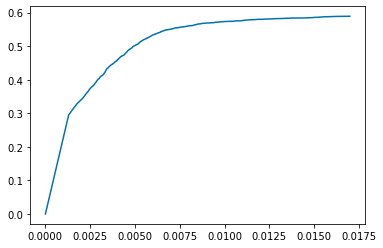

In [79]:
plt.plot(epsilon_i, epsilon_a), 3381+19843

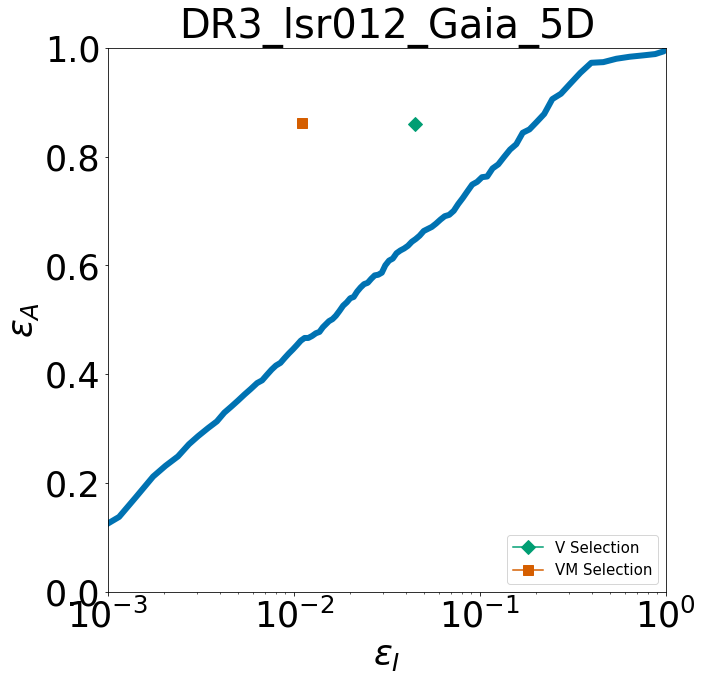

In [26]:
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.plot(epsilon_i, epsilon_a, linewidth=6)
ax.plot(0.045, 0.86, markersize=10, marker='D', label='V Selection')
ax.plot(0.011, 0.862, markersize=10, marker='s', label='VM Selection')
#ax.plot(0.3, 0.1, markersize=20, marker=(5, 1))
ax.set_title(roc_title, fontsize=40)
ax.set_xlabel(r'$\epsilon_I$', fontsize=35)
ax.set_ylabel(r'$\epsilon_A$', fontsize=35)
ax.set_xscale('log')
ax.tick_params(axis='both', labelsize=35)
ax.legend(fontsize=15, loc='lower right')
plt.xlim([0.001,1])
plt.ylim([0,1])
plt.show()



In [57]:
path = '/ocean/projects/phy210068p/hsu1/Training_results/DR2/DR2_m12f_on_m12i_roc_parameters.hdf5'
with h5py.File(path, 'r') as f:
    a4 = f['4D_ep_a'][:]
    i4 = f['4D_ep_i'][:]    

In [58]:
a4

array([1.00000000e+00, 9.95842699e-01, 9.88591594e-01, 9.81582191e-01,
       9.75249559e-01, 9.69883741e-01, 9.64010345e-01, 9.59345467e-01,
       9.54559737e-01, 9.49774007e-01, 9.44988277e-01, 9.40903488e-01,
       9.36867039e-01, 9.32443864e-01, 9.28189882e-01, 9.24225944e-01,
       9.20141155e-01, 9.15863002e-01, 9.11439828e-01, 9.06799120e-01,
       9.02448457e-01, 8.98412008e-01, 8.93505426e-01, 8.89178933e-01,
       8.84296522e-01, 8.79776666e-01, 8.75667706e-01, 8.70906147e-01,
       8.65975395e-01, 8.61262176e-01, 8.55944698e-01, 8.50651391e-01,
       8.46034854e-01, 8.40838228e-01, 8.35520750e-01, 8.29792377e-01,
       8.24740773e-01, 8.19109081e-01, 8.13090663e-01, 8.06685520e-01,
       8.01343872e-01, 7.95905542e-01, 7.89500399e-01, 7.83578662e-01,
       7.77415222e-01, 7.71348464e-01, 7.65450898e-01, 7.58248133e-01,
       7.51963841e-01, 7.44543543e-01, 7.36857371e-01, 7.28881154e-01,
       7.20590723e-01, 7.12300292e-01, 7.03550625e-01, 6.95091001e-01,
      